xESMF Test  adaptive Masking
================
## MPI-ESM1-2 MPIOM (HR: TP04, ~0.5°; LR: GR15, ~1.5°)

### Basic Imports

In [1]:
%matplotlib inline
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import scipy
from clisops.core import subset
import clisops as cl
print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style='html');

import warnings
warnings.simplefilter("ignore") 
#with warnings.catch_warnings():
#        warnings.simplefilter("ignore")

Using roocs/clisops in version 0.4.0
Using xESMF in version 0.5.0


### Load the datasets

In [2]:
# Load intake catalogue
col_url = "/work/ik1017/Catalogs/mistral-cmip6.json"
col = intake.open_esm_datastore(col_url)

# Select tos_Omon and fx_areacello for LR and HR model resolution
#  and historical, historical
cat = col.search(activity_id=["CMIP"], 
                 source_id=["MPI-ESM1-2-HR", "MPI-ESM1-2-LR"],
                 experiment_id=["historical"], 
                 member_id="r1i1p1f1", 
                 variable_id=["tos", "areacello"],
                 table_id=["Omon", "Ofx"])

In [3]:
# Show the available datasets
#cat.df

In [4]:
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {}, 'decode_times': True})

for dict_key in dset_dict.keys(): print(dict_key)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
CMIP.MPI-M.MPI-ESM1-2-HR.historical.Ofx.gn
CMIP.MPI-M.MPI-ESM1-2-LR.historical.Ofx.gn
CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn
CMIP.MPI-M.MPI-ESM1-2-LR.historical.Omon.gn


In [5]:
# Avoid single value coords
#ds = ds.squeeze()               # Remove single-value dimensions from variables
#ds = ds.reset_coords(drop=True) # Remove unused coordinate entries from ds 
                                 # (drops also the "wrong" coordinates (latitude, longitude))
    
# The grid contains unusable rows and columns (halo etc.)
#  - for the LR model, the first and last column have to be removed (indexes 0 and 255)
#  - for the HR model, the first and last column have to be removed (indexes 0 and 801)
#  - for the HR model, also the first two rows have to be removed (indexes 0 and 1)

# Select last 20 years of historical
ds_LR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Omon.gn'].sel(time=slice('2010', '2014')).isel(i=slice(1, 255)).squeeze()
ds_HR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn'].sel(time=slice('2010', '2014')).isel(i=slice(1, 801), j=slice(2,405)).squeeze()
# Select gridcell area
#ds_gridLR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.fx.gn'].squeeze()
#ds_gridHR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.fx.gn'].squeeze()
ds_gridOceLR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Ofx.gn'].isel(i=slice(1, 255)).squeeze()
ds_gridOceHR = dset_dict['CMIP.MPI-M.MPI-ESM1-2-HR.historical.Ofx.gn'].isel(i=slice(1, 801), j=slice(2,405)).squeeze()

### Take a look at the grids

In [6]:
#ds_HR

In [7]:
#ds_LR

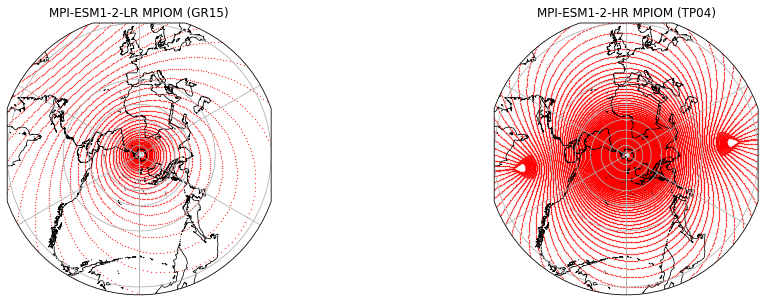

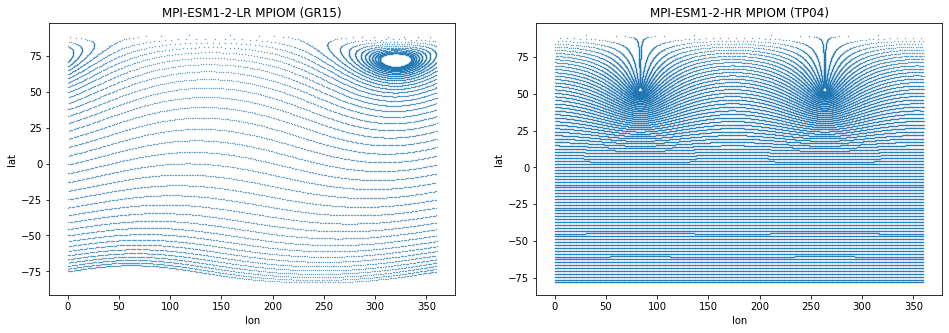

In [8]:
# Plot grid locations LR and HR

# polar projection
def polar_axis():
    '''cartopy geoaxes centered at north pole'''
    # as from https://github.com/JiaweiZhuang/regrid_test/blob/master/debug_bipolar_grid.ipynb
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,5), 
                             subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=0)})
    axes[0].coastlines(linewidth=0.75, color='black', resolution='50m')
    axes[1].coastlines(linewidth=0.75, color='black', resolution='50m')
    axes[0].gridlines(crs=ccrs.PlateCarree(), linestyle='-')
    axes[1].gridlines(crs=ccrs.PlateCarree(), linestyle='-')
    axes[0].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    axes[1].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    return axes

axes=polar_axis()
axes[0].scatter(x=ds_gridOceLR['longitude'][::5], y=ds_gridOceLR['latitude'][::5], s=0.1,
                transform=ccrs.PlateCarree(), c='r')  
axes[1].scatter(x=ds_gridOceHR['longitude'][::5], y=ds_gridOceHR['latitude'][::5], s=0.1,
                transform=ccrs.PlateCarree(), c='r')  

axes[0].set_xlabel('lon');
axes[0].set_ylabel('lat');
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_xlabel('lon');
axes[1].set_ylabel('lat');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');

# common scatter plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
axes[0].scatter(x=ds_gridOceLR['longitude'][::5], y=ds_gridOceLR['latitude'][::5], s=0.1)
axes[1].scatter(x=ds_gridOceHR['longitude'][::5], y=ds_gridOceHR['latitude'][::5], s=0.1)
#axes[1].scatter(x=ds_gridOceHR['longitude'][204, :], y=ds_gridOceHR['latitude'][204, :], s=0.1)
axes[0].set_xlabel('lon');
axes[0].set_ylabel('lat');
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_xlabel('lon');
axes[1].set_ylabel('lat');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
#axes[1].set_ylim([-10, 10]);
#axes[0].set_ylim([-10, 10]);

### Plot the data

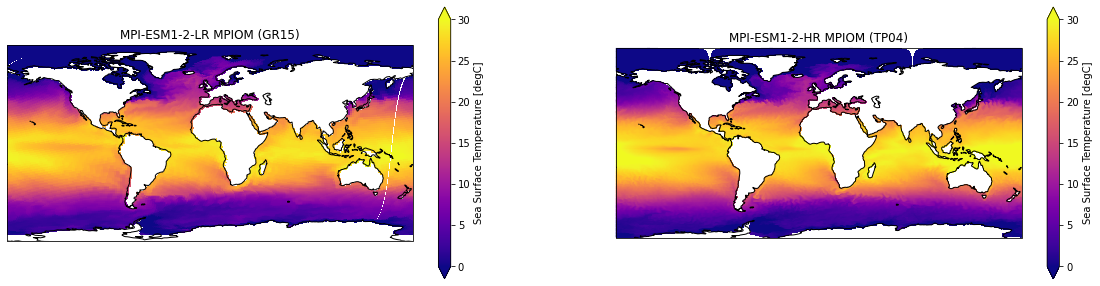

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree()})

ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].coastlines();
axes[1].coastlines();

axes[0].set_xlabel('lon');
axes[0].set_ylabel('lat');
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_xlabel('lon');
axes[1].set_ylabel('lat');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');

### Set up the source and destination grid (interpretable by xESMF)

In [10]:
# Read the target grid (1deg, including land-sea-mask, provided by
#   https://github.com/SantanderMetGroup/ATLAS/blob/master/reference-grids/
ds_out=xr.open_dataset("../../target_grids/land_sea_mask_1degree.nc4")
#ds_out

# Alternatively specify a global grid
# ds_out = xe.util.grid_global(5, 5) # global 5 degree grid
# ds_out

In [11]:
# Calculate the bounds of the target grid
# The bnds cannot be in CF format, as xESMF conservative regridding requires 
#    certain format of the bnds. See eg.:
#    https://github.com/JiaweiZhuang/xESMF/issues/5
#    https://github.com/JiaweiZhuang/xESMF/issues/74
#    https://github.com/JiaweiZhuang/xESMF/issues/14#issuecomment-369686779
#  
# lat_bnds with shape (nlat+1)
lat_bnds=np.zeros(ds_out.lat.shape[0]+1, dtype="double")
lat_bnds[0]=-90.
lat_bnds[-1]=90.
lat_bnds[1:-1]=(ds_out.lat.values[:-1]+ds_out.lat.values[1:])/2.

# lon_bnds with shape (nlon+1)
lon_bnds=np.zeros(ds_out.lon.shape[0]+1, dtype="double")
lon_bnds[0]=-180.
lon_bnds[-1]=180.
lon_bnds[1:-1]=(ds_out.lon.values[:-1]+ds_out.lon.values[1:])/2.
            
# Create dataset with mask
ds_out_mask=xr.Dataset(data_vars={"mask":(["lat", "lon"], xr.where(ds_out['sftlf']==0, 1, 0)),
                                  "lat_b":(["lat1"], lat_bnds),
                                  "lon_b":(["lon1"], lon_bnds)},
                       coords={"lat":(["lat"], ds_out.lat),
                               "lon":(["lon"], ds_out.lon)})

# Create output dataset unmasked
ds_out=xr.Dataset(data_vars={"lat_b":(["lat1"], lat_bnds),
                             "lon_b":(["lon1"], lon_bnds)},
                  coords={"lat":(["lat"], ds_out.lat),
                          "lon":(["lon"], ds_out.lon)})

# Variable attributes
lat_attrs={"bounds":"lat_b",
           "units":"degrees_north",
           "long_name":"latitude",
           "standard_name":"latitude"}
lon_attrs={"bounds":"lon_b",
           "units":"degrees_east",
           "long_name":"longitude",
           "standard_name":"longitude"}

ds_out["lat"].attrs=lat_attrs
ds_out["lon"].attrs=lon_attrs

In [12]:
# Calculate bounds for input grid (assumes variables vertices_latitude, vertices_longitude)
# reshape from (nlat,nlon,4) to (nlat+1,nlon+1)
def translate_grid_for_xesmf(ds, lat_name="latitude", lon_name="longitude", 
                             lat_vert_name="vertices_latitude", lon_vert_name="vertices_longitude"):
    """Reshapes vertices from (nlat,nlon,4) to (nlat+1,nlon+1). Returns xarray.dataset."""
    lat_bnds=np.zeros(tuple([el+1 for el in list(ds[lat_name].shape)]), dtype="double")
    lat_bnds[:-1, :-1]=ds[lat_vert_name][:,:,3]
    lat_bnds[-1, :-1]=ds[lat_vert_name][-1,:,2]
    lat_bnds[:-1, -1]=ds[lat_vert_name][:,-1,1]
    lat_bnds[-1, -1]=ds[lat_vert_name][-1,-1,0]
    
    lon_bnds=np.zeros(tuple([el+1 for el in list(ds[lon_name].shape)]), dtype="double")
    lon_bnds[:-1, :-1]=ds[lon_vert_name][:,:,3]
    lon_bnds[-1, :-1]=ds[lon_vert_name][-1,:,2]
    lon_bnds[:-1, -1]=ds[lon_vert_name][:,-1,1]
    lon_bnds[-1, -1]=ds[lon_vert_name][-1,-1,0]
    
    ds_xesmf=xr.Dataset(data_vars={"lat_b":(["y1","x1"], lat_bnds),
                                   "lon_b":(["y1","x1"], lon_bnds)},
                        coords={"lat":(["y","x"], ds[lat_name].values),
                                "lon":(["y","x"], ds[lon_name].values)})        
    return ds_xesmf

In [13]:
# Translate the input grid to be conformal with xESMF
ds_in_LR=translate_grid_for_xesmf(ds_LR)
ds_in_HR=translate_grid_for_xesmf(ds_HR)

# incl. mask
ds_in_LR_mask=translate_grid_for_xesmf(ds_LR)
ds_in_LR_mask["mask"]=xr.where(~np.isnan(ds_LR['tos'].isel(time=0)), 1, 0).astype(int)
ds_in_HR_mask=translate_grid_for_xesmf(ds_HR)
ds_in_HR_mask["mask"]=xr.where(~np.isnan(ds_HR['tos'].isel(time=0)), 1, 0).astype(int)

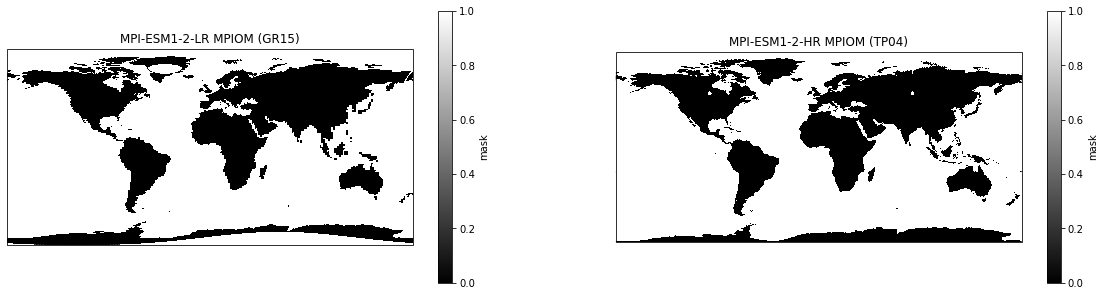

In [14]:
# Plot the masks
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree()})
ds_in_LR_mask.mask.plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='binary_r');
ds_in_HR_mask.mask.plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='binary_r');
axes[0].set_xlabel('lon');
axes[0].set_ylabel('lat');
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_xlabel('lon');
axes[1].set_ylabel('lat');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');

### Create regridding weights in 3 fashions

#### 1  conservative - Source Grid (unmasked) to Target Grid (unmasked)
The mask of the input grid is not accounted for when creating the regridding weights.
That causes missing values where masked source cells contribute to a target cell, 
whenever masked data is then regridded using this weights.

#### 2  conservative_normed - Source Grid (masked) to Target Grid (unmasked) incl. out-of-source-domain Masking
The mask of the input grid is accounted for when creating the regridding weights.   
The conservative_normed method is used so that a renormalization is applied.
Thereafter the add_matrix_NaNs method is applied.

#### 3 conservative - Source Grid (unmasked) to Target Grid (unmasked) incl. Adaptive and out-of-source-domain Masking
The mask of the input grid is not accounted for when creating the regridding weights.
The proper masking and renormalization is done using the "Adaptive Masking" approach and 
applying the out-of-source-domain masking (add_matrix_NaNs) method on the regridding weights.

For more information see: https://github.com/roocs/regrid-prototype/blob/main/docs/notebooks/xESMF_nonpermanent_masks.ipynb

Adaptive masking has been suggested by stefraynaud (https://github.com/pangeo-data/xESMF/issues/29#issuecomment-714252254) and Matthew Long (https://github.com/NCAR/esmlab-regrid/blob/master/esmlab_regrid/core.py#L147).
The out-of-source-domain masking (add_matrix_NaNs function) has been suggested by Nic Wayand (https://github.com/JiaweiZhuang/xESMF/issues/15#issuecomment-371646763).

#### 3.1 define a minimum contribution threshold for adaptive masking

An addition to the adaptive masking / renormalization method would be to apply a minimum threshold of contributing source cell area to the target grid cell. In this way one could allow the renormalization only if at least for example 80% of the source cells' area that contribute to a target cell is not masked. Else the result will be a missing value.

In [15]:
def add_matrix_NaNs(regridder):
    """Add Nans to matrices, which makes any output cell with a weight from a NaN input cell = NaN"""
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    # indptr: https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
    # Creates array with length nrows+1 with information about non-zero values,
    #  with np.diff calculating how many non-zero elements there are in each row
    num_nonzeros = np.diff(M.indptr) 
    # Setting rows with only zeros to NaN
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

def adaptive_masking(ds_in, regridder, min_norm_contribution=1):
    """Performs regridding incl. renormalization for conservative weights"""    
    validi = ds_in.notnull().astype('d')
    valido = regridder(validi)
    tempi0 = ds_in.fillna(0)
    tempo0 = regridder(tempi0)
    # min_norm_contribution factor could prevent values for cells that should be masked.
    # It prevents the renormalization for cells that get less than min_norm_contribution 
    #  from source cells. If the factor==0.66 it means that at most one third of the source cells' area
    #  contributing to the target cell is masked. This factor has however to be tweaked manually for each 
    #  pair of source and destination grid.
    if min_norm_contribution<1:
        valido = xr.where(valido < min_norm_contribution, np.nan, valido)
    ds_out = xr.where(valido != 0, tempo0 / valido, np.nan)
    return ds_out

In [16]:
# Create regridding weights
# Fixes applied: https://github.com/JiaweiZhuang/xESMF/pull/61
# from https://github.com/JiaweiZhuang/xESMF/issues/60

# In case of problems, activate ESMF verbose mode
import ESMF
ESMF.Manager(debug=True)

# Regridding methods
method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']

# Function to generate the weights
def regrid(ds_in, ds_out, method, periodic, ignore_degenerate=None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic=periodic, ignore_degenerate=ignore_degenerate) 

In [17]:
# Generating the weights for LR_to_destination, HR_to_destination regridding
#   Both grids have problems of degenerated cells near the poles and thus require the ignore_degenerate option
regridderLR={}
regridderHR={}

# 1 conservative
#################
print("conservative")
%time regridderLR["conservative"]=regrid(ds_in_LR, ds_out, "conservative", periodic=True, ignore_degenerate=None)    
print(regridderLR["conservative"])  
print()
%time regridderHR["conservative"]=regrid(ds_in_HR, ds_out, "conservative", periodic=True, ignore_degenerate=None)
print(regridderHR["conservative"])  


# 2 conservative_normed
########################
print("\nconservative_normed")
%time regridderLR["conservative_normed"]=regrid(ds_in_LR_mask, ds_out, "conservative_normed", periodic=True, ignore_degenerate=None)    
print(regridderLR["conservative_normed"])  
print()
%time regridderHR["conservative_normed"]=regrid(ds_in_HR_mask, ds_out, "conservative_normed", periodic=True, ignore_degenerate=None)
print(regridderHR["conservative_normed"]) 
# Apply Masking of out-of-domain-values
regridderLR["conservative_normed"]=add_matrix_NaNs(regridderLR["conservative_normed"])
regridderHR["conservative_normed"]=add_matrix_NaNs(regridderHR["conservative_normed"])


# 3 Apply Masking of out-of-domain-values
#   to the conservative weights
##########################################
regridderLR["conservative_NaN"]=add_matrix_NaNs(regridderLR["conservative"])
regridderHR["conservative_NaN"]=add_matrix_NaNs(regridderHR["conservative"])

conservative
CPU times: user 4.79 s, sys: 112 ms, total: 4.91 s
Wall time: 4.89 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_220x254_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (220, 254) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 14.4 s, sys: 472 ms, total: 14.9 s
Wall time: 14.8 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_402x800_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (402, 800) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

conservative_normed
CPU times: user 3.92 s, sys: 114 ms, total: 4.04 s
Wall time: 4.02 s
xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_220x254_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (220, 254) 
Output grid

In [18]:
# Perform regridding

# 1 conservative
ds_out["tos_LR_conservative"]=regridderLR["conservative"](ds_LR.tos)
ds_out["tos_HR_conservative"]=regridderHR["conservative"](ds_HR.tos)

# 2 conservative_normed
ds_out["tos_LR_conservative_normed"]=regridderLR["conservative_normed"](ds_LR.tos)
ds_out["tos_HR_conservative_normed"]=regridderHR["conservative_normed"](ds_HR.tos)

# 3 conservative with adaptive masking
ds_out["tos_LR_conservative_adaptive-masking"]=adaptive_masking(ds_LR.tos, regridderLR["conservative_NaN"])
ds_out["tos_HR_conservative_adaptive-masking"]=adaptive_masking(ds_HR.tos, regridderHR["conservative_NaN"]) 

# 3.1 conservative with adaptive masking & contribution threshold
ds_out["tos_LR_conservative_adaptive-masking_threshold"]=adaptive_masking(ds_LR.tos, regridderLR["conservative_NaN"], 0.8)
ds_out["tos_HR_conservative_adaptive-masking_threshold"]=adaptive_masking(ds_HR.tos, regridderHR["conservative_NaN"], 0.8) 

### Plot regridded data

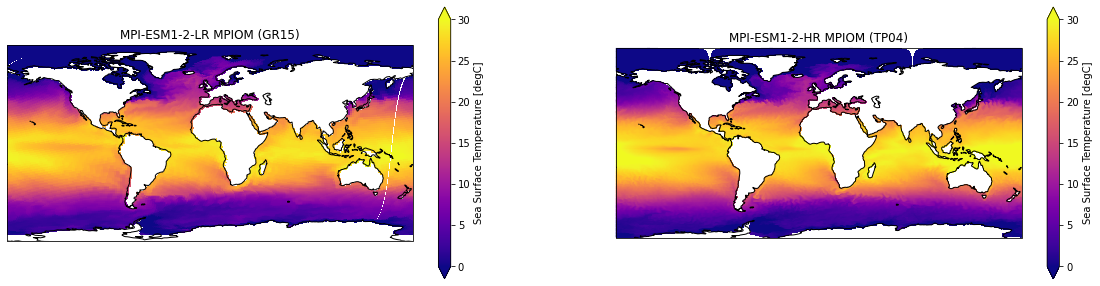

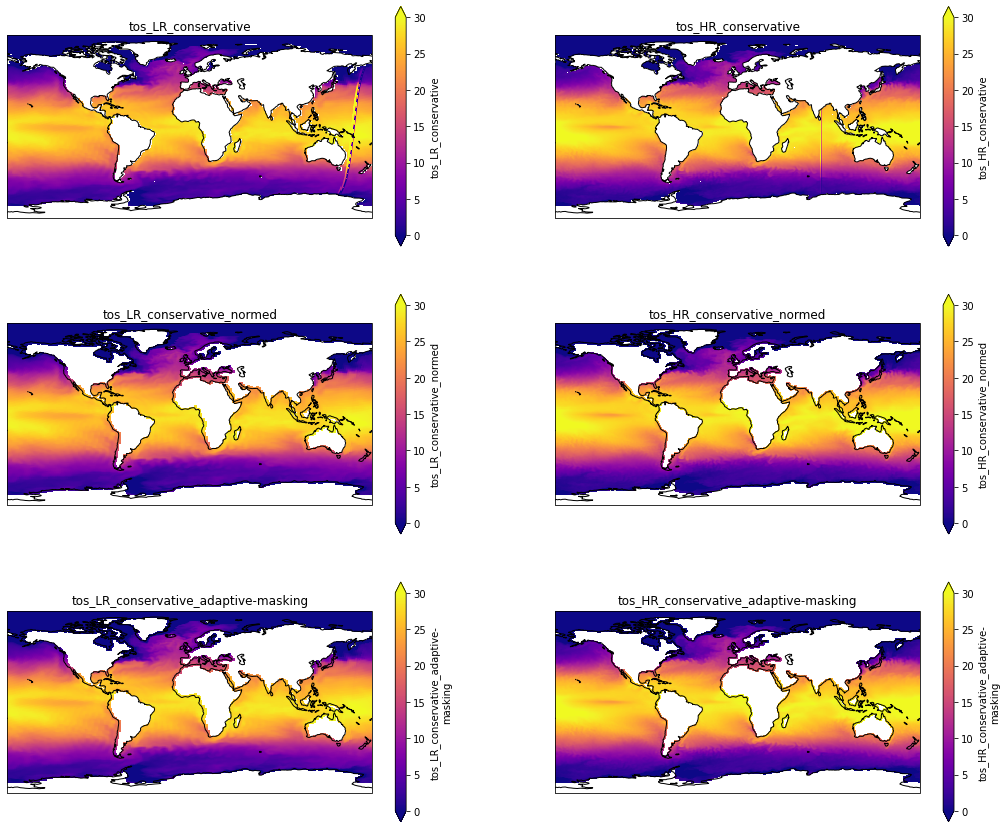

In [19]:
import textwrap

# Create 1st panel plot (data on original grid)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree()})
ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');

# Create panel plot of regridded data
fig, axes = plt.subplots(ncols=2, nrows=3, 
                         figsize=(18, 15), # global
                         #figsize=(10, 12), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})
    
# Regridded data (from LR)
ds_out["tos_LR_conservative"].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=0, vmax=30, cmap="plasma")
axes[0,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative", 40)));    
       
# Regridded data (from HR)        
ds_out["tos_HR_conservative"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=0, vmax=30, cmap="plasma")
axes[0,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative", 40))); 
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=0, vmax=30, cmap="plasma")
axes[1,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=0, vmax=30, cmap="plasma")
axes[1,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking"].isel(time=0).plot.pcolormesh(ax=axes[2,0], vmin=0, vmax=30, cmap="plasma")
axes[2,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking"].isel(time=0).plot.pcolormesh(ax=axes[2,1], vmin=0, vmax=30, cmap="plasma")
axes[2,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking", 40)));

# Coast lines and limits
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');

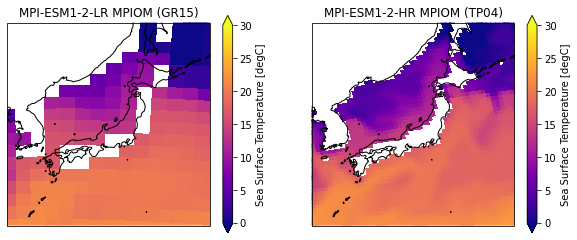

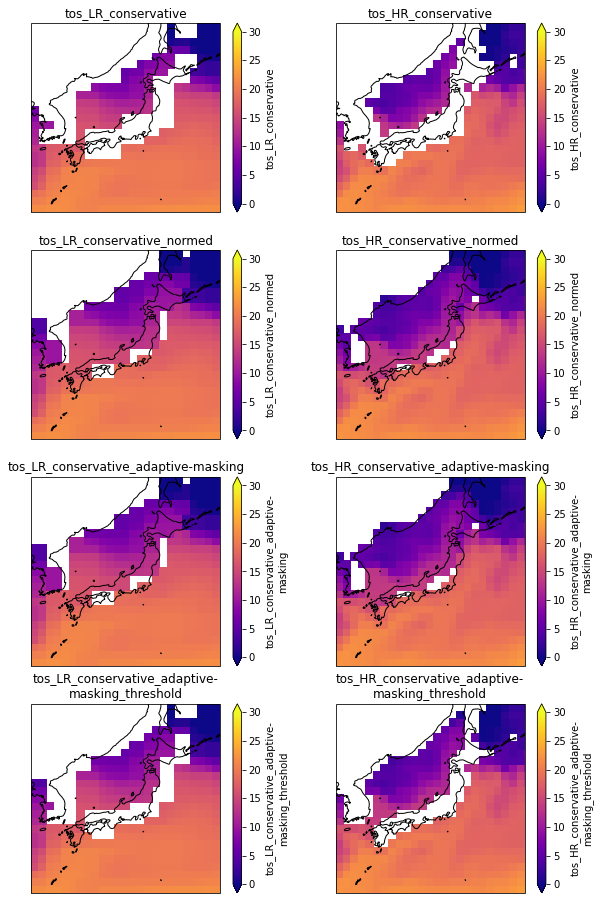

In [20]:
# Create 1st panel plot (data on original grid) for Japan
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

# Create panel plot of regridded data for Japan
fig, axes = plt.subplots(ncols=2, nrows=4, 
                         #figsize=(18, 15), # global
                         figsize=(10, 16), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})
    
# Regridded data (from LR)
ds_out["tos_LR_conservative"].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=0, vmax=30, cmap="plasma")
axes[0,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative", 40)));    
       
# Regridded data (from HR)        
ds_out["tos_HR_conservative"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=0, vmax=30, cmap="plasma")
axes[0,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative", 40))); 
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=0, vmax=30, cmap="plasma")
axes[1,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=0, vmax=30, cmap="plasma")
axes[1,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking"].isel(time=0).plot.pcolormesh(ax=axes[2,0], vmin=0, vmax=30, cmap="plasma")
axes[2,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking"].isel(time=0).plot.pcolormesh(ax=axes[2,1], vmin=0, vmax=30, cmap="plasma")
axes[2,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking", 40)));

# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking_threshold"].isel(time=0).plot.pcolormesh(ax=axes[3,0], vmin=0, vmax=30, cmap="plasma")
axes[3,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking_threshold", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking_threshold"].isel(time=0).plot.pcolormesh(ax=axes[3,1], vmin=0, vmax=30, cmap="plasma")
axes[3,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking_threshold", 40)));

# Coast lines and limits
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

### Remarks/Questions:
1. The conservative method gives a band of missing values despite the "periodic=True" setting. This band of missing values is located where the original grid has its eastern and western bounds and is visible in the original data as well. Should the periodic setting be set to False in this case?

2. The add_matrix_NaNs functionality is already implemented in xESMF from version 0.4. However it is only applied when an output mask is specified. Is there any way to also apply this method via xESMF when not specifiying an output mask?




### Further investigations:
1. Should a common land-sea-mask be applied to the result?
2. Specify output mask for the conservative_normed and conservative methods for the generation of regridding weights. 
3. It should be investigated if the variable is conserved globally for each of the regridding procedures above, or in other words by how much the adaptive masking changes the global mean of the variable with respect to the conservative normed method or the original data.

### 1. Should a common land-sea-mask be applied to the result?

In [21]:
# Apply the common land-sea-mask of the output grid
# Create dataset with and without mask
ds_out["tos_LR_conservative_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_LR_conservative"])
ds_out["tos_HR_conservative_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_HR_conservative"])
ds_out["tos_LR_conservative_normed_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_LR_conservative_normed"])
ds_out["tos_HR_conservative_normed_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_HR_conservative_normed"])
ds_out["tos_LR_conservative_adaptive-masking_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_LR_conservative_adaptive-masking"])
ds_out["tos_HR_conservative_adaptive-masking_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_HR_conservative_adaptive-masking"])
ds_out["tos_LR_conservative_adaptive-masking_threshold_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_LR_conservative_adaptive-masking_threshold"])
ds_out["tos_HR_conservative_adaptive-masking_threshold_lsm"]=xr.where(ds_out_mask['mask']==0, np.nan, ds_out["tos_HR_conservative_adaptive-masking_threshold"])

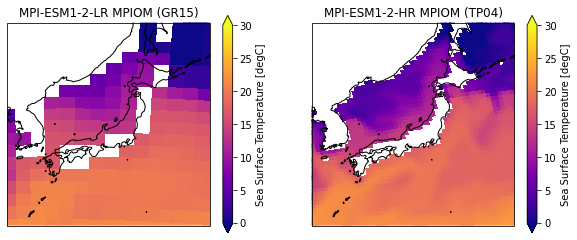

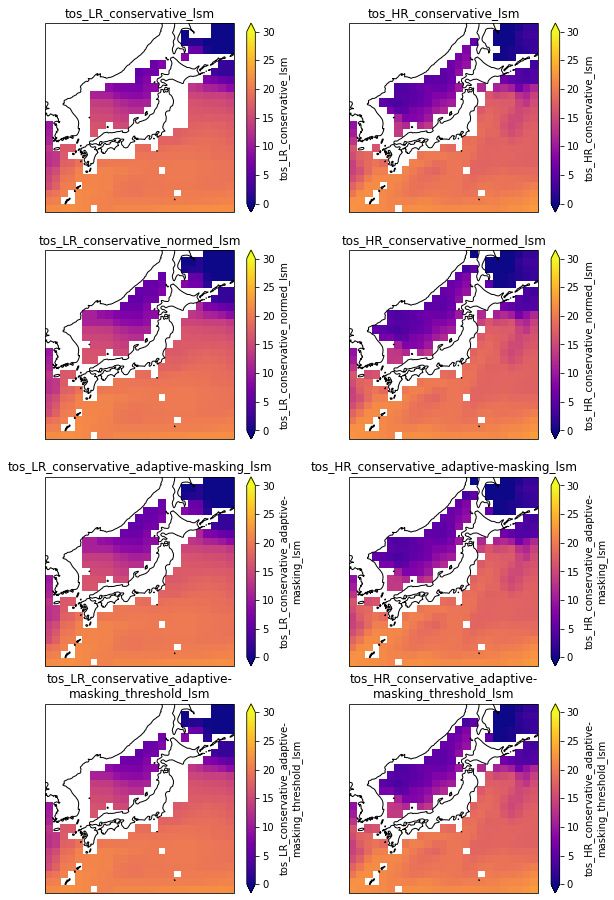

In [22]:
# Create 1st panel plot (data on original grid) for Japan
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

# Create panel plot of regridded data for Japan
fig, axes = plt.subplots(ncols=2, nrows=4, 
                         #figsize=(18, 15), # global
                         figsize=(10, 16), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})
    
# Regridded data (from LR)
ds_out["tos_LR_conservative_lsm"].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=0, vmax=30, cmap="plasma")
axes[0,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_lsm", 40)));    
       
# Regridded data (from HR)        
ds_out["tos_HR_conservative_lsm"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=0, vmax=30, cmap="plasma")
axes[0,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_lsm", 40))); 
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed_lsm"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=0, vmax=30, cmap="plasma")
axes[1,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed_lsm", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed_lsm"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=0, vmax=30, cmap="plasma")
axes[1,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed_lsm", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,0], vmin=0, vmax=30, cmap="plasma")
axes[2,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking_lsm", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,1], vmin=0, vmax=30, cmap="plasma")
axes[2,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking_lsm", 40)));

# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking_threshold_lsm"].isel(time=0).plot.pcolormesh(ax=axes[3,0], vmin=0, vmax=30, cmap="plasma")
axes[3,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking_threshold_lsm", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking_threshold_lsm"].isel(time=0).plot.pcolormesh(ax=axes[3,1], vmin=0, vmax=30, cmap="plasma")
axes[3,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking_threshold_lsm", 40)));

# Coast lines and limits
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

### 2. Specify output mask for the conservative_normed and conservative methods for the generation of regridding weights. 

#### Create regridding weights in two more fashions

#### 4  conservative - Source Grid (masked) to Target Grid (masked)
Masked values are counted as "0". That causes some side effects when applying the regridding weights on data that has missing values.

#### 5  conservative_normed - Source Grid (masked) to Target Grid (masked) incl. out-of-source-domain Masking
The mask of the input grid is accounted for when creating the regridding weights.   
The conservative_normed method is used so that a renormalization is applied.
Thereafter the add_matrix_NaNs method is applied.

In [23]:
# 4 conservative masked source and target grid
###############################################
print("conservative - masked source and target grid")
%time regridderLR["conservative_m-to-m"]=regrid(ds_in_LR_mask, ds_out_mask, "conservative", \
                                                periodic=True, ignore_degenerate=None)    
print(regridderLR["conservative_m-to-m"])  
print()
%time regridderHR["conservative_m-to-m"]=regrid(ds_in_HR_mask, ds_out_mask, "conservative", \
                                                periodic=True, ignore_degenerate=None)
print(regridderHR["conservative_m-to-m"])  


# 5 conservative_normed masked source and target grid
######################################################
print("\nconservative_normed - masked source and target grid")
%time regridderLR["conservative_normed_m-to-m"]=regrid(ds_in_LR_mask, ds_out_mask, "conservative_normed", \
                                                       periodic=True, ignore_degenerate=None)    
print(regridderLR["conservative_normed_m-to-m"])  
print()
%time regridderHR["conservative_normed_m-to-m"]=regrid(ds_in_HR_mask, ds_out_mask, "conservative_normed", \
                                                       periodic=True, ignore_degenerate=None)
print(regridderHR["conservative_normed_m-to-m"]) 

conservative - masked source and target grid
CPU times: user 4.16 s, sys: 103 ms, total: 4.26 s
Wall time: 4.24 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_220x254_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (220, 254) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 11.4 s, sys: 374 ms, total: 11.8 s
Wall time: 11.8 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_402x800_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (402, 800) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

conservative_normed - masked source and target grid
CPU times: user 3.88 s, sys: 120 ms, total: 4 s
Wall time: 3.98 s
xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_220x254_180x360.nc 
Reuse pre-computed weight

In [24]:
# Perform regridding

# 4 conservative masked source and target grid
ds_out["tos_LR_conservative_m-to-m"]=regridderLR["conservative_m-to-m"](ds_LR.tos)
ds_out["tos_HR_conservative_m-to-m"]=regridderHR["conservative_m-to-m"](ds_HR.tos)

# 5 conservative_normed masked source and target grid
ds_out["tos_LR_conservative_normed_m-to-m"]=regridderLR["conservative_normed_m-to-m"](ds_LR.tos)
ds_out["tos_HR_conservative_normed_m-to-m"]=regridderHR["conservative_normed_m-to-m"](ds_HR.tos)

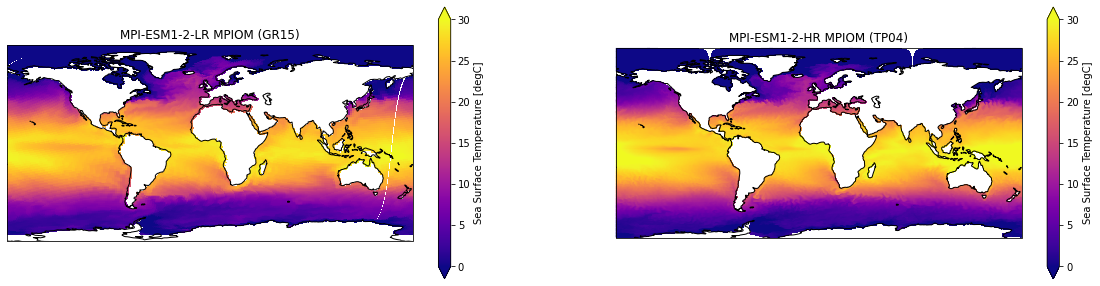

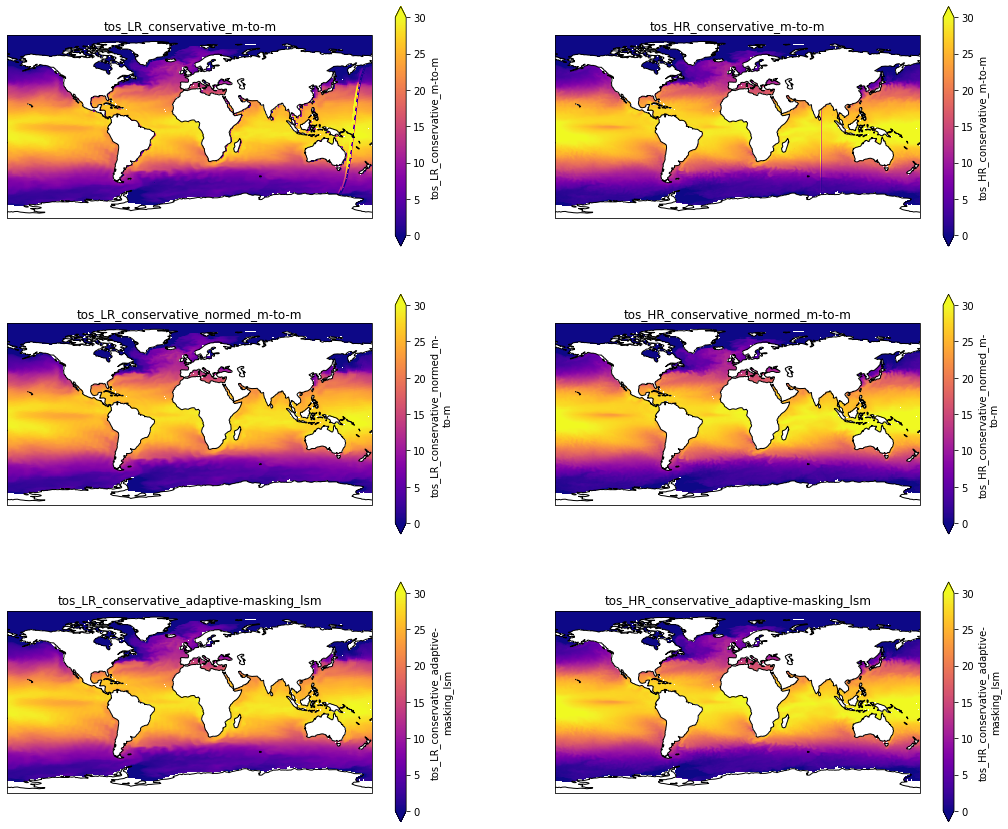

In [25]:
# Create 1st panel plot (data on original grid)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree()})
ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');

# Create panel plot of regridded data
fig, axes = plt.subplots(ncols=2, nrows=3, 
                         figsize=(18, 15), # global
                         #figsize=(10, 12), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})
    
# Regridded data (from LR)
ds_out["tos_LR_conservative_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=0, vmax=30, cmap="plasma")
axes[0,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_m-to-m", 40)));    
       
# Regridded data (from HR)        
ds_out["tos_HR_conservative_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=0, vmax=30, cmap="plasma")
axes[0,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_m-to-m", 40))); 
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=0, vmax=30, cmap="plasma")
axes[1,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed_m-to-m", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=0, vmax=30, cmap="plasma")
axes[1,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed_m-to-m", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_adaptive-masking_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,0], vmin=0, vmax=30, cmap="plasma")
axes[2,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_adaptive-masking_lsm", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_adaptive-masking_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,1], vmin=0, vmax=30, cmap="plasma")
axes[2,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_adaptive-masking_lsm", 40)));

# Coast lines and limits
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');

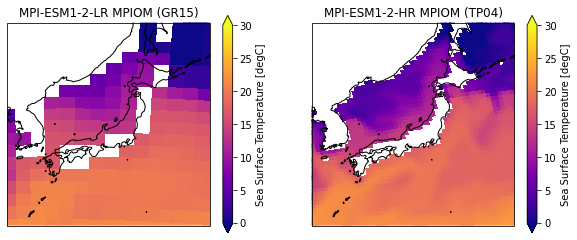

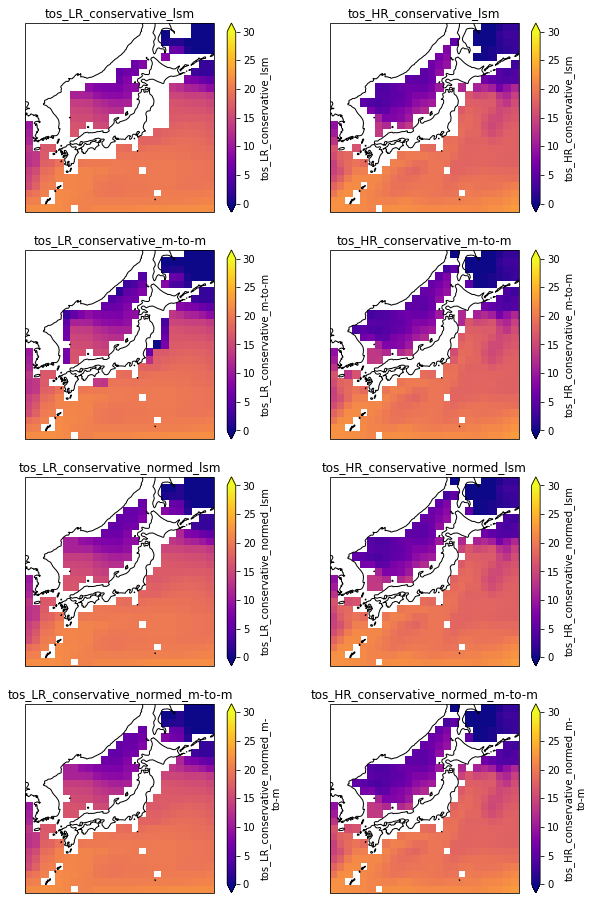

In [26]:
# Create 1st panel plot (data on original grid) for Japan
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_LR.tos.isel(time=0).plot.pcolormesh(ax=axes[0], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
ds_HR.tos.isel(time=0).plot.pcolormesh(ax=axes[1], x='longitude', y='latitude', 
                                       shading='flat', cmap='plasma', vmin=0, vmax=30);
axes[0].set_title('MPI-ESM1-2-LR MPIOM (GR15)');
axes[1].set_title('MPI-ESM1-2-HR MPIOM (TP04)');
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

# Create panel plot of regridded data for Japan
fig, axes = plt.subplots(ncols=2, nrows=4, 
                         #figsize=(18, 15), # global
                         figsize=(10, 16), # Japan
                         subplot_kw={'projection': ccrs.PlateCarree()})
    
# Regridded data (from LR)
ds_out["tos_LR_conservative_lsm"].isel(time=0).plot.pcolormesh(ax=axes[0,0], vmin=0, vmax=30, cmap="plasma")
axes[0,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_lsm", 40)));    
       
# Regridded data (from HR)        
ds_out["tos_HR_conservative_lsm"].isel(time=0).plot.pcolormesh(ax=axes[0,1], vmin=0, vmax=30, cmap="plasma")
axes[0,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_lsm", 40))); 

# Regridded data (from LR)
ds_out["tos_LR_conservative_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[1,0], vmin=0, vmax=30, cmap="plasma")
axes[1,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_m-to-m", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[1,1], vmin=0, vmax=30, cmap="plasma")
axes[1,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_m-to-m", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,0], vmin=0, vmax=30, cmap="plasma")
axes[2,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed_lsm", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed_lsm"].isel(time=0).plot.pcolormesh(ax=axes[2,1], vmin=0, vmax=30, cmap="plasma")
axes[2,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed_lsm", 40)));
        
# Regridded data (from LR)
ds_out["tos_LR_conservative_normed_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[3,0], vmin=0, vmax=30, cmap="plasma")
axes[3,0].title.set_text("\n".join(textwrap.wrap("tos_LR_conservative_normed_m-to-m", 40))); 
        
# Regridded data (from HR)        
ds_out["tos_HR_conservative_normed_m-to-m"].isel(time=0).plot.pcolormesh(ax=axes[3,1], vmin=0, vmax=30, cmap="plasma")
axes[3,1].title.set_text("\n".join(textwrap.wrap("tos_HR_conservative_normed_m-to-m", 40)));

# Coast lines and limits
for axis in axes.flatten():
    axis.coastlines();
    axis.set_xlabel('lon');
    axis.set_ylabel('lat');
    axis.set_xlim([125, 150]);
    axis.set_ylim([25, 50]);

### 3. Compare global means

In [27]:
# Calculate area of 1deg grid
rE = 6371000 # Earth radius [m]
#cell_area is approx. by rE * dlat * cos(lat_cellcenter) * dlon * rE 
area = (np.deg2rad(1.0)*rE) * (np.deg2rad(1.0)* rE * \
                               np.cos(np.deg2rad(ds_out.lat))).values.reshape((180,1)) * \
                               np.ones((ds_out.lat.shape[0], ds_out.lon.shape[0]))
area.shape, area 

((180, 360), array([[1.07897605e+08, 1.07897605e+08, 1.07897605e+08, ...,
         1.07897605e+08, 1.07897605e+08, 1.07897605e+08],
        [3.23659949e+08, 3.23659949e+08, 3.23659949e+08, ...,
         3.23659949e+08, 3.23659949e+08, 3.23659949e+08],
        [5.39323702e+08, 5.39323702e+08, 5.39323702e+08, ...,
         5.39323702e+08, 5.39323702e+08, 5.39323702e+08],
        ...,
        [5.39323702e+08, 5.39323702e+08, 5.39323702e+08, ...,
         5.39323702e+08, 5.39323702e+08, 5.39323702e+08],
        [3.23659949e+08, 3.23659949e+08, 3.23659949e+08, ...,
         3.23659949e+08, 3.23659949e+08, 3.23659949e+08],
        [1.07897605e+08, 1.07897605e+08, 1.07897605e+08, ...,
         1.07897605e+08, 1.07897605e+08, 1.07897605e+08]]))

In [28]:
# Calculate global means of the regridded fields for each month 
#  and compute difference with respect to LR/HR global mean

mask_method_list=["conservative", "conservative_lsm", "conservative_m-to-m",
                  "conservative_normed", "conservative_normed_lsm", "conservative_normed_m-to-m",
                  "conservative_adaptive-masking", "conservative_adaptive-masking_lsm"]

ds_HR_glob=xr.Dataset(data_vars={"tos_HR_"+method: ("time", np.zeros(12, dtype="float32")) for method in mask_method_list},
                        coords={'month': ('time', np.arange(12))})
ds_HR_glob["tos"]=xr.DataArray(np.zeros(12, dtype="float32"), coords=[np.arange(12)], dims=['time'])


ds_LR_glob=xr.Dataset(data_vars={"tos_LR_"+method: ("time", np.zeros(12, dtype="float32")) for method in mask_method_list},
                        coords={'month': ('time', np.arange(12))})
ds_LR_glob["tos"]=xr.DataArray(np.zeros(12, dtype="float32"), coords=[np.arange(12)], dims=['time'])

ds_LR_glob
for month in range(12):
    indices=~np.isnan(ds_LR["tos"].isel(time=month).values)
    ds_LR_glob["tos"][month]=np.average(ds_LR["tos"].isel(time=month).values[indices], weights=ds_gridOceLR["areacello"].values[indices])
    indices=~np.isnan(ds_HR["tos"].isel(time=month).values)
    ds_HR_glob["tos"][month]=np.average(ds_HR["tos"].isel(time=month).values[indices], weights=ds_gridOceHR["areacello"].values[indices])

    for method in mask_method_list:
        indices=~np.isnan(ds_out["tos_LR_"+method].isel(time=month).values)
        ds_LR_glob["tos_LR_"+method][month]=np.average(ds_out["tos_LR_"+method].isel(time=month).values[indices], weights=area[indices])
        indices=~np.isnan(ds_out["tos_HR_"+method].isel(time=month).values)
        ds_HR_glob["tos_HR_"+method][month]=np.average(ds_out["tos_HR_"+method].isel(time=month).values[indices], weights=area[indices])

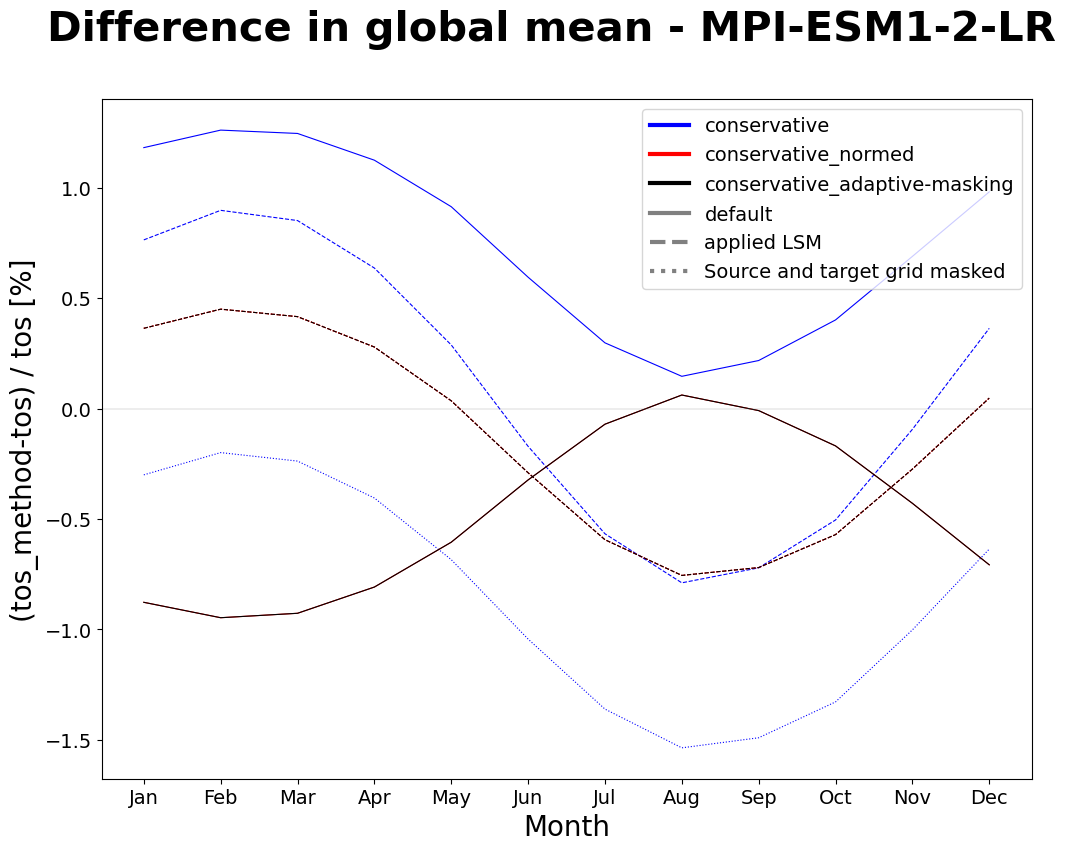

In [29]:
from matplotlib.lines import Line2D
from calendar import month_abbr

# Plot the results - LR
fig = plt.figure(num=None, figsize=(12, 9), dpi=100, facecolor='w', edgecolor='k');
ax  = plt.axes();
colors=["blue", "red", "black"]
linestyles=["solid", "dashed", "dotted"]

for method in mask_method_list:   
    ax.plot(range(12), 
            (ds_LR_glob["tos_LR_"+method]-ds_LR_glob["tos"])*100/ds_LR_glob["tos"], 
            #ds_LR_glob["tos_LR_"+method],
            color=colors[int(mask_method_list.index(method)/3)],
            linewidth=0.8,
            linestyle=linestyles[int(mask_method_list.index(method)%3)]);
    
# Axes and Titles
ax.tick_params(axis='both', which='major', labelsize=14);
plt.xticks(np.arange(12), [month_abbr[i+1] for i in range(12)]);
ax.set_xlabel("Month", fontsize=20);
ax.set_ylabel("(tos_method-tos) / tos [%]", fontsize=20);
#ax.set_title("tos", fontsize=20)
fig.suptitle("Difference in global mean - MPI-ESM1-2-LR", fontsize=30, fontweight="bold")

# Vertical Line at 0
ax.axhline(y=0, xmin=-1, xmax=12, color='grey', linewidth=0.2)

# Legend
lines=[Line2D([0], [0], color=c, linewidth=3) for c in colors]+ \
      [Line2D([0], [0], color="grey", linewidth=3, linestyle=l) for l in linestyles]
legend=["conservative", "conservative_normed", "conservative_adaptive-masking",
       "default", "applied LSM", "Source and target grid masked"]
plt.legend(lines, legend, loc='best', fontsize=14);

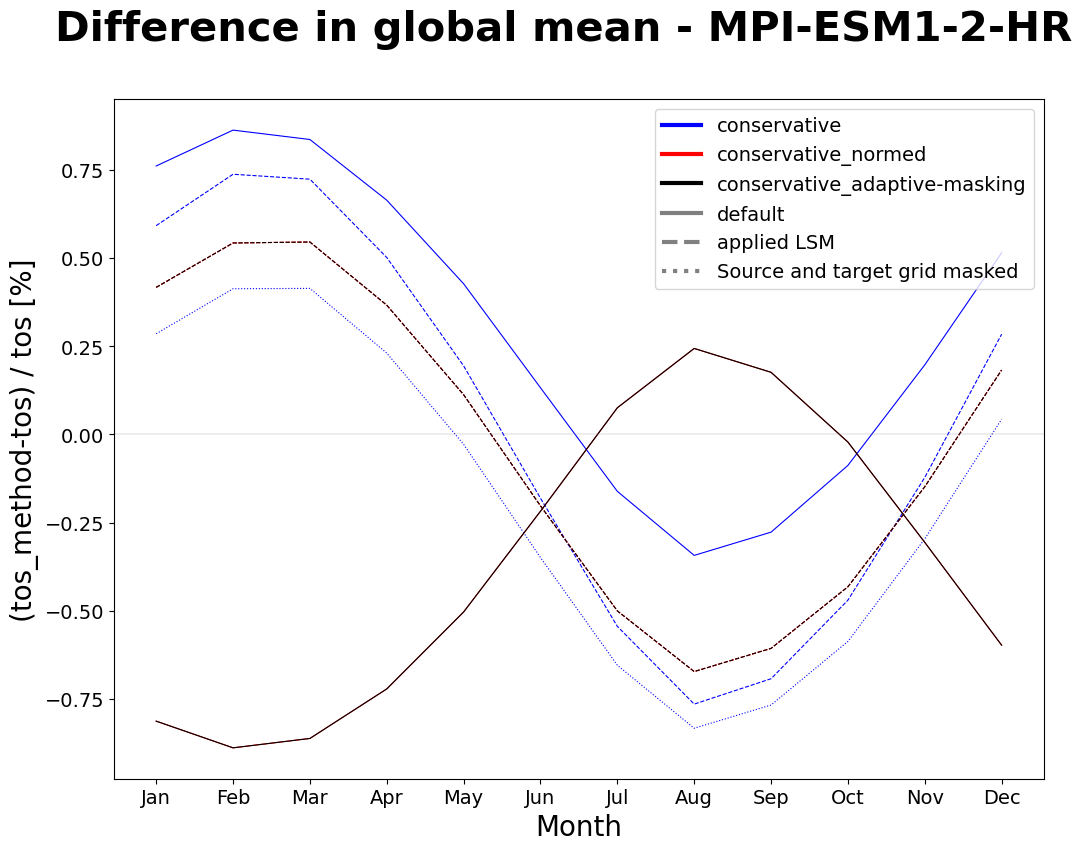

In [30]:
# Plot the results - LR
fig = plt.figure(num=None, figsize=(12, 9), dpi=100, facecolor='w', edgecolor='k');
ax  = plt.axes();
colors=["blue", "red", "black"]
linestyles=["solid", "dashed", "dotted"]

for method in mask_method_list:   
    #print(method, np.mean((ds_LR_glob["tos_LR_"+method]-ds_LR_glob["tos"])*100/ds_LR_glob["tos"]))
    ax.plot(range(12), 
            (ds_HR_glob["tos_HR_"+method]-ds_HR_glob["tos"])*100/ds_HR_glob["tos"], 
            #ds_HR_glob["tos_HR_"+method],
            color=colors[int(mask_method_list.index(method)/3)],
            linewidth=0.8,
            linestyle=linestyles[int(mask_method_list.index(method)%3)]);    
    
# Axes and Titles
ax.tick_params(axis='both', which='major', labelsize=14);
plt.xticks(np.arange(12), [month_abbr[i+1] for i in range(12)]);
ax.set_xlabel("Month", fontsize=20);
ax.set_ylabel("(tos_method-tos) / tos [%]", fontsize=20);
#ax.set_title("tos", fontsize=20)
fig.suptitle("Difference in global mean - MPI-ESM1-2-HR", fontsize=30, fontweight="bold")

# Vertical Line at 0
ax.axhline(y=0, xmin=-1, xmax=12, color='grey', linewidth=0.2)

# Legend
lines=[Line2D([0], [0], color=c, linewidth=3) for c in colors]+ \
      [Line2D([0], [0], color="grey", linewidth=3, linestyle=l) for l in linestyles]
legend=["conservative", "conservative_normed", "conservative_adaptive-masking",
       "default", "applied LSM", "Source and target grid masked"]
plt.legend(lines, legend, loc='best', fontsize=14);

For the conservative method there are differences between 'unmasked to unmasked', 'masked to masked' and 'unasked to unmasked with applied LSM'.
But there is no difference between conservative_normed 'masked to masked' / 'masked to unmasked with applied LSM' and conservative 'unmasked to unmasked with adaptive masking and applied LSM'.
There is also no difference between conservative_normed and conservative 'unmasked to unmasked with adaptive masking'.
##### - That shows that adaptive masking (post regridding normalization) can be used as normalization method in place of generating  conservative_normed weights, which allows to reuse regridding weights and to apply normalization and masks after regridding. This is useful when the mask changes for different vertical levels or different variables. 
##### - Also it appears that there is no difference between conservative_normed 'masked to masked' and 'masked to unmasked with applied LSM'.
##### - It seems that add_matrix_NaNs as implemented in xESMF is not called if no target mask is specified when generating the weights. Is there an option that can be specified to call add_matrix_NaNs regardless?